In [1]:
import scipy.io, math, os
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

In [8]:
from tslearn.barycenters import \
    euclidean_barycenter, \
    dtw_barycenter_averaging, \
    dtw_barycenter_averaging_subgradient, \
    softdtw_barycenter
from tslearn.datasets import CachedDatasets

In [4]:
def get_srate(file_number): # can create a utils.py or a utils directory and imports utility functions from there (especially if you reuse them across notebooks/scripts)
    directory = 'data/Data/F1/mat'
    
    # still needs to ignore the .DS_Store file in a better way
    file = sorted(os.listdir(directory))[file_number + 1]
    
    f = os.path.join(directory, file)
    mat = scipy.io.loadmat(f)['usctimit_ema_f1_{:03}_{:03}'.format(file_number*5 + 1, file_number*5 + 5)]
    
    #returns the srate which is stored here
    return mat[0][1][1][0][0]

In [7]:
def get_pos_list(position, file_number, starting_point, end_point):
    xyz_list = []

    if position == 'UL':
        for i in range(end_point - starting_point):
            coordinate = (UL_df[file_number][0][starting_point + i],
                          UL_df[file_number][1][starting_point + i],
                          UL_df[file_number][2][starting_point + i])

            xyz_list.append(coordinate)
            
    if position == 'LL':
        for i in range(end_point - starting_point):
            coordinate = (LL_df[file_number][0][starting_point + i],
                          LL_df[file_number][1][starting_point + i],
                          LL_df[file_number][2][starting_point + i])

            xyz_list.append(coordinate)
            
    if position == 'JW':
        for i in range(end_point - starting_point):
            coordinate = (JW_df[file_number][0][starting_point + i],
                          JW_df[file_number][1][starting_point + i],
                          JW_df[file_number][2][starting_point + i])

            xyz_list.append(coordinate)
            
    if position == 'TB':
        for i in range(end_point - starting_point):
            coordinate = (TB_df[file_number][0][starting_point + i],
                          TB_df[file_number][1][starting_point + i],
                          TB_df[file_number][2][starting_point + i])

            xyz_list.append(coordinate)
            
    if position == 'TD':
        for i in range(end_point - starting_point):
            coordinate = (TD_df[file_number][0][starting_point + i],
                          TD_df[file_number][1][starting_point + i],
                          TD_df[file_number][2][starting_point + i])

            xyz_list.append(coordinate)
            
    if position == 'TT':
        for i in range(end_point - starting_point):
            coordinate = (TT_df[file_number][0][starting_point + i],
                          TT_df[file_number][1][starting_point + i],
                          TT_df[file_number][2][starting_point + i])

            xyz_list.append(coordinate)
        
    return xyz_list

In [5]:
directory = 'data/Data/F1/mat'
counter = 1
UL_df, LL_df, JW_df, TD_df, TB_df, TT_df = [], [], [], [], [], []

for filename in sorted(os.listdir(directory)):
    if filename.endswith('.mat'):
        f = os.path.join(directory, filename)
        mat = scipy.io.loadmat(f)
        # takes the data that is stored at the key that precedes the data for each .mat file
        data = mat['usctimit_ema_f1_{:03}_{:03}'.format(counter, counter + 4)]
        counter += 5

        # make dataframes of the six positions
        UL_df.append(pd.DataFrame.from_dict(data[0][1][2]))
        LL_df.append(pd.DataFrame.from_dict(data[0][2][2]))
        JW_df.append(pd.DataFrame.from_dict(data[0][3][2]))
        TD_df.append(pd.DataFrame.from_dict(data[0][4][2]))
        TB_df.append(pd.DataFrame.from_dict(data[0][5][2]))
        TT_df.append(pd.DataFrame.from_dict(data[0][6][2]))

In [8]:
frames = {}
word_number = 0

with open('timestamps.txt', 'r') as file:
    timestamps = file.read().splitlines()
    for line in timestamps:
        split_line = line.split(',')
        sent_number = int(split_line[-1])
        
        # find start and end by multiplying the timestamps with the sampling rate
        starting_point = math.floor(float(split_line[2]) * get_srate(int(split_line[0])))
        end_point = math.ceil(float(split_line[3]) * get_srate(int(split_line[0])))
        
        # make dataframe for each word, so 3481 dataframes
        data = {'word' : [split_line[1]],
                'srate': [get_srate(int(split_line[0]))],
                'sent' : [int(split_line[-1])],
                'UL'   : [get_pos_list('UL', int(split_line[0]), starting_point, end_point)],
                'LL'   : [get_pos_list('LL', int(split_line[0]), starting_point, end_point)],
                'JW'   : [get_pos_list('JW', int(split_line[0]), starting_point, end_point)],
                'TD'   : [get_pos_list('TD', int(split_line[0]), starting_point, end_point)],
                'TB'   : [get_pos_list('TB', int(split_line[0]), starting_point, end_point)],
                'TT'   : [get_pos_list('TT', int(split_line[0]), starting_point, end_point)]}
        
        df = pd.DataFrame(data)
        frames[word_number] = df
        word_number += 1

In [10]:
def get_key(val, dictionary):
    instances = []
    
    # retrieves the numbers of the instances of the word we are looking for in a list
    for key, value in dictionary.items():
        if val == value['word'][0]:
            instances.append(key)
    
    return instances

In [11]:
word_instances = {}

for frame in frames:
    if frames[frame]['word'][0] in word_instances:
        continue
    
    word_instances[frames[frame]['word'][0]] = get_key(frames[frame]['word'][0], frames)

In [12]:
word_instances['this']

[0, 1018, 1184, 1516, 1818, 1845, 2342, 2398, 2583, 2825, 3001, 3069, 3313]

In [13]:
def make_trajectory_plot(word_dataframe, fixed_axes=False, twoD=False):
    
    x_UL, y_UL, z_UL = [], [], []
    for coordinate in word_dataframe['UL'][0]:
        x_UL.append(coordinate[0])
        y_UL.append(coordinate[1])
        z_UL.append(coordinate[2])
    
    x_LL, y_LL, z_LL = [], [], []
    for coordinate in word_dataframe['LL'][0]:
        x_LL.append(coordinate[0])
        y_LL.append(coordinate[1])
        z_LL.append(coordinate[2])
        
    x_JW, y_JW, z_JW = [], [], []
    for coordinate in word_dataframe['JW'][0]:
        x_JW.append(coordinate[0])
        y_JW.append(coordinate[1])
        z_JW.append(coordinate[2])
        
    x_TB, y_TB, z_TB = [], [], []
    for coordinate in word_dataframe['TB'][0]:
        x_TB.append(coordinate[0])
        y_TB.append(coordinate[1])
        z_TB.append(coordinate[2])
        
    x_TD, y_TD, z_TD = [], [], []
    for coordinate in word_dataframe['TD'][0]:
        x_TD.append(coordinate[0])
        y_TD.append(coordinate[1])
        z_TD.append(coordinate[2])
        
    x_TT, y_TT, z_TT = [], [], []
    for coordinate in word_dataframe['TT'][0]:
        x_TT.append(coordinate[0])
        y_TT.append(coordinate[1])
        z_TT.append(coordinate[2])
    
    # makes all the axis this size, currently 
    if fixed_axes:
        ax.set_xlim3d(  13,  15)
        ax.set_ylim3d( -72, -67)
        ax.set_zlim3d(-2.5, 2.5)
    
    if not twoD:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        ax.plot3D(x_UL, y_UL, z_UL, label = 'UL')
        ax.plot3D(x_LL, y_LL, z_LL, label = 'LL')
        ax.plot3D(x_JW, y_JW, z_JW, label = 'JW')
        ax.plot3D(x_TB, y_TB, z_TB, label = 'TB')
        ax.plot3D(x_TD, y_TD, z_TD, label = 'TD')
        ax.plot3D(x_TT, y_TT, z_TT, label = 'TT')
        
    if twoD:
        plt.plot(x_UL, y_UL, label = 'UL')
        plt.plot(x_LL, y_LL, label = 'LL')
        plt.plot(x_JW, y_JW, label = 'JW')
        plt.plot(x_TB, y_TB, label = 'TB')
        plt.plot(x_TD, y_TD, label = 'TD')
        plt.plot(x_TT, y_TT, label = 'TT')
    
    plt.legend(loc = 'lower left')
    plt.title(str(word_dataframe['word'][0]) + ', ' + str(word_dataframe['sent'][0]))
    plt.show()

In [48]:
pd.DataFrame([w['word'][0] for w in frames.values()])[0].value_counts()[:50]

the        216
a           95
in          56
to          53
and         49
is          45
of          39
for         36
are         34
you         33
was         26
on          23
with        23
be          21
from        18
her         16
by          15
your        15
i           15
will        14
this        13
his         13
an          13
have        13
that        13
as          13
not         12
all         12
do          11
every       10
my          10
big         10
each        10
they         9
can          9
we           9
at           8
new          8
their        8
often        8
may          8
she          8
much         7
only         7
allow        7
through      6
up           6
many         6
out          6
when         6
Name: 0, dtype: int64

In [49]:
word_instances['often']

[207, 1140, 1144, 2173, 2873, 2975, 3080, 3256]

In [19]:
frames[537]

,word,srate,sent,UL,LL,JW,TD,TB,TT
0,project,100.081953,85,"[(13.761367615580767, -56.50633188469287, 0.54...","[(14.009899558413288, -67.76913310824483, -1.6...","[(-1.6174819536353198, -79.6050789235324, 3.81...","[(-47.690160039474236, -57.33097640630458, 0.2...","[(-36.48769662540414, -53.88565686659598, 0.68...","[(-28.718666971072356, -56.79234153527295, -2...."


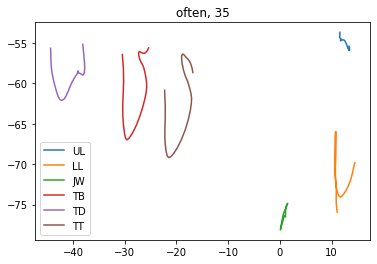

In [57]:
make_trajectory_plot(frames[207], fixed_axes=False, twoD=True)

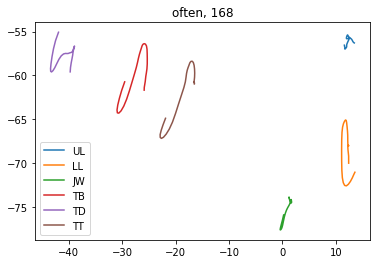

In [56]:
make_trajectory_plot(frames[1140], fixed_axes=False, twoD=True)

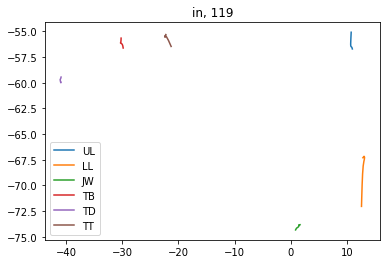

In [53]:
make_trajectory_plot(frames[782], fixed_axes=False, twoD=True)